In [1]:
#!pip install tensorflow==1.14.0

In [2]:
#!pip install keras==2.2.5

In [3]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [4]:
import os
os.environ["PYTHONHASHSEED"] = "13"
os.environ["CUDA_VISIBLE_DEVICES"] = "0:1"

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(13)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(13)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(13)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [5]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13290889655177492993
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4338570539148225288
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3790083959447138486
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14941647668
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7917141360032168946
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"
]


In [7]:
import gc
import warnings

#import lightgbm as lgb
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout

path_data = "../input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

myfavouritenumber = 13
seed = myfavouritenumber

warnings.filterwarnings("ignore")

In [8]:
site_id = 8

In [9]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train)
weather_test = pd.read_csv(path_weather_test)

weather_train.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)
weather_test.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)

weather_train = weather_train.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
weather_test = weather_test.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))

df_train = df_train.merge(building, on="building_id")
df_test = df_test.merge(building, on="building_id")

df_train = df_train[df_train.site_id == site_id]
df_test = df_test[df_test.site_id == site_id]

df_train = df_train[~((df_train.building_id == 848) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 815) & (df_train.meter_reading == 0))]

df_train = df_train.merge(weather_train, on=["site_id", "timestamp"], how="left")
df_test = df_test.merge(weather_test, on=["site_id", "timestamp"], how="left")

df_train.timestamp = pd.to_datetime(df_train.timestamp, format='%Y-%m-%d %H:%M:%S')
df_test.timestamp = pd.to_datetime(df_test.timestamp, format='%Y-%m-%d %H:%M:%S')

df_train.building_id = df_train.building_id.astype("str")
df_test.building_id = df_test.building_id.astype("str")

df_train["log_meter_reading"] = np.log1p(df_train.meter_reading)

del building
gc.collect()

148

In [10]:
df_train["hour"] = df_train.timestamp.dt.hour.astype("str")
df_test["hour"] = df_test.timestamp.dt.hour.astype("str")

df_train["weekday"] = df_train.timestamp.dt.weekday.astype("str")
df_test["weekday"] = df_test.timestamp.dt.weekday.astype("str")

df_train["month"] = df_train.timestamp.dt.month.astype("str")
df_test["month"] = df_test.timestamp.dt.month.astype("str")

In [11]:
features = [
    "building_id",
    "square_feet",
    "year_built",
    "floor_count",
    "primary_use",
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "hour",
    "weekday",
    "month"
]

In [12]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [13]:
cv = 5
folds = KFold(n_splits = cv, shuffle = False, random_state = seed)

df_cv = []
df_preds = []

Building Model for site_id 8 and meter 0
Preparing Site: 8 , meter: 0 , Fold: 1



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 449609 samples, validate on 112403 samples
Epoch 1/41


 - 27s - loss: 2.3022 - val_loss: 1.2882
Epoch 2/41
 - 2s - loss: 1.5581 - val_loss: 1.6050
Epoch 3/41
 - 2s - loss: 1.4763 - val_loss: 1.5430
Epoch 4/41
 - 2s - loss: 1.4309 - val_loss: 1.5117
Epoch 5/41
 - 2s - loss: 1.4087 - val_loss: 1.5501
Epoch 6/41
 - 2s - loss: 1.3975 - val_loss: 1.5710
Epoch 7/41
 - 2s - loss: 1.3923 - val_loss: 1.4233
Epoch 8/41
 - 2s - loss: 1.3868 - val_loss: 1.5206
Epoch 9/41
 - 2s - loss: 1.3825 - val_loss: 1.4504
Epoch 10/41
 - 2s - loss: 1.3784 - val_loss: 1.4062
Epoch 11/41
 - 2s - loss: 1.3753 - val_loss: 1.4245
Epoch 12/41
 - 2s - loss: 1.3740 - val_loss: 1.4085
Epoch 13/41
 - 2s - loss: 1.3714 - 

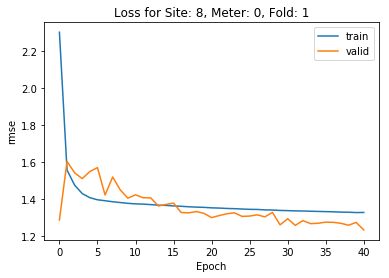

CPU times: user 32.3 s, sys: 2.07 s, total: 34.3 s
Wall time: 26.1 s
Preparing Site: 8 , meter: 0 , Fold: 2
Train on 449609 samples, validate on 112403 samples
Epoch 1/41
 - 3s - loss: 2.2117 - val_loss: 1.1996
Epoch 2/41
 - 2s - loss: 1.6435 - val_loss: 1.1124
Epoch 3/41
 - 2s - loss: 1.5745 - val_loss: 1.1299
Epoch 4/41
 - 2s - loss: 1.5340 - val_loss: 1.1388
Epoch 5/41
 - 2s - loss: 1.5140 - val_loss: 1.0905
Epoch 6/41
 - 2s - loss: 1.5047 - val_loss: 1.1205
Epoch 7/41
 - 2s - loss: 1.4986 - val_loss: 1.0786
Epoch 8/41
 - 2s - loss: 1.4933 - val_loss: 1.0746
Epoch 9/41
 - 2s - loss: 1.4899 - val_loss: 1.0704
Epoch 10/41
 - 2s - loss: 1.4868 - val_loss: 1.0692
Epoch 11/41
 - 2s - loss: 1.4854 - val_loss: 1.0747
Epoch 12/41
 - 2s - loss: 1.4818 - val_loss: 1.0553
Epoch 13/41
 - 2s - loss: 1.4787 - val_loss: 1.0620
Epoch 14/41
 - 2s - loss: 1.4770 - val_loss: 1.0527
Epoch 15/41
 - 2s - loss: 1.4757 - val_loss: 1.0705
Epoch 16/41
 - 2s - loss: 1.4741 - val_loss: 1.0810
Epoch 17/41
 - 2s

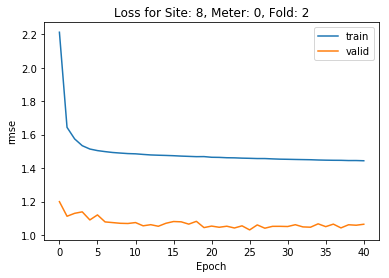

CPU times: user 33.9 s, sys: 2.05 s, total: 35.9 s
Wall time: 27.6 s
Preparing Site: 8 , meter: 0 , Fold: 3
Train on 449610 samples, validate on 112402 samples
Epoch 1/41
 - 3s - loss: 2.1562 - val_loss: 1.2139
Epoch 2/41
 - 2s - loss: 1.6307 - val_loss: 1.0084
Epoch 3/41
 - 2s - loss: 1.5800 - val_loss: 0.9972
Epoch 4/41
 - 2s - loss: 1.5448 - val_loss: 1.0763
Epoch 5/41
 - 2s - loss: 1.5260 - val_loss: 0.9773
Epoch 6/41
 - 2s - loss: 1.5134 - val_loss: 1.0804
Epoch 7/41
 - 2s - loss: 1.5053 - val_loss: 0.9977
Epoch 8/41
 - 2s - loss: 1.5013 - val_loss: 1.0108
Epoch 9/41
 - 2s - loss: 1.4967 - val_loss: 0.9959
Epoch 10/41
 - 2s - loss: 1.4937 - val_loss: 1.0263
Epoch 11/41
 - 2s - loss: 1.4913 - val_loss: 0.9962
Epoch 12/41
 - 2s - loss: 1.4894 - val_loss: 1.0416
Epoch 13/41
 - 2s - loss: 1.4865 - val_loss: 0.9910
Epoch 14/41
 - 2s - loss: 1.4849 - val_loss: 1.0219
Epoch 15/41
 - 2s - loss: 1.4813 - val_loss: 1.0269
Epoch 16/41
 - 2s - loss: 1.4796 - val_loss: 1.0225
Epoch 17/41
 - 2s

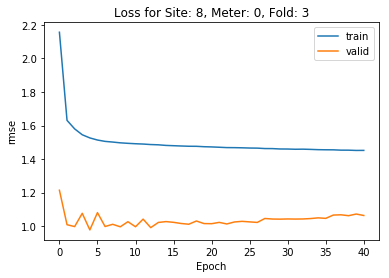

CPU times: user 35.2 s, sys: 2.03 s, total: 37.3 s
Wall time: 29 s
Preparing Site: 8 , meter: 0 , Fold: 4
Train on 449610 samples, validate on 112402 samples
Epoch 1/41
 - 4s - loss: 2.0799 - val_loss: 1.6566
Epoch 2/41
 - 2s - loss: 1.4757 - val_loss: 1.7440
Epoch 3/41
 - 2s - loss: 1.4240 - val_loss: 1.7344
Epoch 4/41
 - 2s - loss: 1.3876 - val_loss: 1.7179
Epoch 5/41
 - 2s - loss: 1.3686 - val_loss: 1.6539
Epoch 6/41
 - 2s - loss: 1.3591 - val_loss: 1.6575
Epoch 7/41
 - 2s - loss: 1.3529 - val_loss: 1.6372
Epoch 8/41
 - 2s - loss: 1.3481 - val_loss: 1.6094
Epoch 9/41
 - 2s - loss: 1.3439 - val_loss: 1.6052
Epoch 10/41
 - 2s - loss: 1.3408 - val_loss: 1.5890
Epoch 11/41
 - 2s - loss: 1.3381 - val_loss: 1.5989
Epoch 12/41
 - 2s - loss: 1.3355 - val_loss: 1.5909
Epoch 13/41
 - 2s - loss: 1.3342 - val_loss: 1.5949
Epoch 14/41
 - 2s - loss: 1.3312 - val_loss: 1.5883
Epoch 15/41
 - 2s - loss: 1.3290 - val_loss: 1.5759
Epoch 16/41
 - 2s - loss: 1.3268 - val_loss: 1.5893
Epoch 17/41
 - 2s -

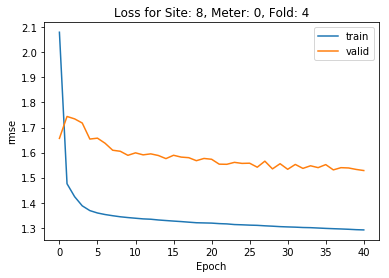

CPU times: user 35.9 s, sys: 1.88 s, total: 37.7 s
Wall time: 29.5 s
Preparing Site: 8 , meter: 0 , Fold: 5
Train on 449610 samples, validate on 112402 samples
Epoch 1/41
 - 4s - loss: 2.0100 - val_loss: 2.1045
Epoch 2/41
 - 2s - loss: 1.4964 - val_loss: 1.6688
Epoch 3/41
 - 2s - loss: 1.4172 - val_loss: 1.7359
Epoch 4/41
 - 2s - loss: 1.3809 - val_loss: 1.5027
Epoch 5/41
 - 2s - loss: 1.3597 - val_loss: 1.5612
Epoch 6/41
 - 2s - loss: 1.3499 - val_loss: 1.5246
Epoch 7/41
 - 2s - loss: 1.3439 - val_loss: 1.5078
Epoch 8/41
 - 2s - loss: 1.3386 - val_loss: 1.4904
Epoch 9/41
 - 2s - loss: 1.3349 - val_loss: 1.4584
Epoch 10/41
 - 2s - loss: 1.3322 - val_loss: 1.5258
Epoch 11/41
 - 2s - loss: 1.3305 - val_loss: 1.4808
Epoch 12/41
 - 2s - loss: 1.3277 - val_loss: 1.5335
Epoch 13/41
 - 2s - loss: 1.3250 - val_loss: 1.4631
Epoch 14/41
 - 2s - loss: 1.3234 - val_loss: 1.5157
Epoch 15/41
 - 2s - loss: 1.3221 - val_loss: 1.4964
Epoch 16/41
 - 2s - loss: 1.3192 - val_loss: 1.5279
Epoch 17/41
 - 2s

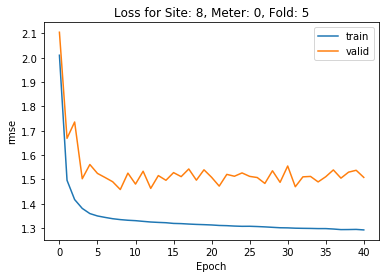

CPU times: user 37.5 s, sys: 1.86 s, total: 39.3 s
Wall time: 31 s

CV RMSE for Site: 8 and Meter: 0 is 1.5109369219333861

CV RMSE for Site: 8 is 1.5109369219333861


In [14]:
for meter in df_train.meter.unique():
    print("Building Model for site_id", site_id, "and meter", meter)
        
    df_train_site_meter = df_train[df_train.meter == meter].reset_index(drop=True)
    df_test_site_meter = df_test[df_test.meter == meter].reset_index(drop=True)
    
    pred_val = np.zeros(df_train_site_meter.shape[0])
    pred_test = np.zeros(df_test_site_meter.shape[0])

    row_ids_test = df_test_site_meter.row_id
    y_train_site_meter = df_train_site_meter.log_meter_reading.values
    
    df_train_site_meter = df_train_site_meter[features]
    df_test_site_meter = df_test_site_meter[features]

    df_train_site_meter = pd.get_dummies(df_train_site_meter)
    df_test_site_meter = pd.get_dummies(df_test_site_meter)
        
    for k, (train_idx, valid_idx) in enumerate(folds.split(df_train_site_meter, y_train_site_meter)):
        print("Preparing Site:", site_id, ", meter:", meter, ", Fold:", k+1)
        
        X_train, y_train = df_train_site_meter.iloc[train_idx], y_train_site_meter[train_idx]
        X_valid, y_valid = df_train_site_meter.iloc[valid_idx], y_train_site_meter[valid_idx]
        
        X_train.dropna(axis=1, how="all", inplace=True)
        X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]

        X_valid = X_valid[X_train.columns]
        X_test = df_test_site_meter[X_train.columns]
        
        df_means = pd.concat([X_train, X_valid, X_test], ignore_index=True).mean()
        X_train.fillna(df_means, inplace=True)
        X_valid.fillna(df_means, inplace=True)
        X_test.fillna(df_means, inplace=True)
        
        sc = MinMaxScaler()
        sc.fit(pd.concat([X_train, X_valid, X_test], ignore_index=True))
        
        X_train = np.array(sc.transform(X_train))
        X_valid = np.array(sc.transform(X_valid))
        X_test = np.array(sc.transform(X_test))
        
        model = Sequential()
        model.add(Dense(512, input_dim=X_train.shape[1], activation="relu", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(128, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(16, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=rmse, optimizer="adam")
        
        model_ffnn = model.fit(X_train, y_train, epochs=41, batch_size=1300, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

        plt.plot(model_ffnn.history["loss"])
        plt.plot(model_ffnn.history["val_loss"])
        plt.title("Loss for Site: " + str(site_id) + ", Meter: " + str(meter) + ", Fold: " + str(k+1))
        plt.ylabel("rmse")
        plt.xlabel("Epoch")
        plt.legend(["train", "valid"], loc="upper right")
        plt.show()
        
        pred_val[valid_idx] = model.predict(X_valid).ravel()
        %time pred_test += model.predict(X_test).ravel() / cv
        
        gc.collect()
        
    df_valid = pd.DataFrame({"site_id": site_id, "meter": meter, "meter_reading": np.expm1(y_train_site_meter), "pred_ffnn": np.clip(np.expm1(pred_val), 0, a_max=None)})
    df_pred = pd.DataFrame({"row_id": row_ids_test, "meter_reading": np.clip(np.expm1(pred_test), 0, a_max=None)})
    
    df_cv.append(df_valid)
    df_preds.append(df_pred)
    
    gc.collect()
    
    print("\nCV RMSE for Site:", site_id, "and Meter:", meter, "is", np.sqrt(mean_squared_error(np.log1p(df_valid.meter_reading), np.log1p(df_valid.pred_ffnn))))

df_cv = pd.concat(df_cv)
print("\nCV RMSE for Site:", site_id, "is", np.sqrt(mean_squared_error(np.log1p(df_cv.meter_reading), np.log1p(df_cv.pred_ffnn))))


In [15]:
df_preds = pd.concat(df_preds)
df_preds.to_csv("../sub/ffnn_pred_site_" + str(site_id) + ".csv", index=False)